In [10]:
from data.SLP_RD import SLP_RD
from data.SLP_FD import SLP_FD
import argparse
import utils.vis as vis
import utils.utils as ut
import numpy as np
import opt
import cv2
import skimage
import model.A2J as model
import model.anchor as anchor
import math
import torch
from tqdm import tqdm
import json
from os import path

In [6]:
opts = opt.parseArgs()
# opt.print_options(opts)
model_dir = 'output/A2J/model_dump/ITOP_side.pth'    # hardwired due in this test case
# feeder
SLP_rd = SLP_RD(opts, phase='test')       #
SLP_fd = SLP_FD(SLP_rd, opts)

# itop df
joints_name_itop = (
		"Head", "Thorax", "R_Shoulder", "L_Shoulder", "R_Elbow", "L_Elbow", "R_Wrist", "L_Wrist", "Pelvis", "R_Hip",
		"L_Hip", "R_Knee", "L_Knee", "R_Ankle", "L_Ankle")  # max std joints, first joint_num_ori will be true labeled
skels_name_itop = (
		('Pelvis', 'Thorax'),
		('Thorax', 'Head'),
		('Thorax', 'R_Shoulder'), ('R_Shoulder', 'R_Elbow'), ('R_Elbow', 'R_Wrist'),
		('Thorax', 'L_Shoulder'), ('L_Shoulder', 'L_Elbow'), ('L_Elbow', 'L_Wrist'),
		('Pelvis', 'R_Hip'),
		('R_Hip', 'R_Knee'), ('R_Knee', 'R_Ankle'),
		('Pelvis', 'L_Hip'),
		('L_Hip', 'L_Knee'), ('L_Knee', 'L_Ankle'),
	)
skels = ut.nameToIdx(skels_name_itop, joints_name_itop)



test_dataloaders = torch.utils.data.DataLoader(SLP_fd, batch_size=opts.batch_size,
                                               shuffle=False, num_workers=0)
dl_iter = iter(test_dataloaders)
itr_per_epoch = math.ceil(
	SLP_fd.__len__() / opts.num_gpus / opts.batch_size)  # single ds test on batch share
if opts.testIter > 0:
	itr_per_epoch = min(itr_per_epoch, opts.testIter)

In [7]:
net = model.A2J_model(num_classes=15)   # 15 is for itop
net.load_state_dict(torch.load(model_dir))
net = net.cuda()
net.eval()
post_precess = anchor.post_process(shape=[288//16,288//16],stride=16,P_h=None, P_w=None)

# save the jts, pth_desc
output = torch.FloatTensor()
itr_per_epoch = 1       # comment for full test
with torch.no_grad():
	for i in tqdm(range(itr_per_epoch)):        # loop all test
		img, label = next(dl_iter)
		img, label = img.cuda(), label.cuda()
		heads = net(img)
		pred_keypoints = post_precess(heads, voting=False)  #
		output = torch.cat([output, pred_keypoints.data.cpu()], 0)  # N x n_jt x  3 (x,y:pix, depth:pix?)

100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


In [ ]:
# check values
# print('img shape', img.size())
result = output.cpu().data.numpy()      # N x n_jt x 3 [ 3: pix] 
result = SLP_fd.A2J_postProc(result)    # rotate change bias center  [x,y:pix, z:m]
n_test = len(result)

In [8]:
## save preds and desc
sv_preds={}
sv_preds['pth_desc'] = SLP_rd.pthDesc_li[:n_test]
sv_preds['preds_3d'] = result.tolist()  # list format
ut.make_folder(opts.rst_dir)
svPth = path.join(opts.rst_dir, 'SLP_test_3d.json')
with open(svPth,'w') as f:
	json.dump(sv_preds, f, allow_nan = True)

# read in to test
with open(svPth) as f:
	preds_in = json.load(f)
print(preds_in['pth_desc'])
print(preds_in['SLP_test_3d.json'])

img shape torch.Size([60, 1, 288, 288])


In [ ]:
## idx test
# idx batch, for loop fd._len_,  get gen 3 img, sv, use another loop to combine

sv_dir = opts.vis_test_dir
for idx_show in tqdm(range(n_test)):       # for single test, change here
# 	idx_show = 30
	jts_cam, jts_ori = SLP_rd.bb2cam(result)
	jt_ori = jts_ori[idx_show]
	jt_cam = jts_cam[idx_show]
	dpR, jt, bb = SLP_rd.get_array_joints(idx_show, mod='depthRaw')
	RGB, jt_R, bb_R = SLP_rd.get_array_joints(idx_show, mod='RGB')
	jt_R[:,2] =1
	dpR_norm = ut.normImg(dpR)
	# get patch
	# pch, jt_pch = SLP_fd.SLP_A2J(idx_show)
	# jt_pch[:,2] = 1 - jt_pch[:,2]
	# pch = pch.transpose([1,2,0])    # to cv2 format
	# pch_nm = ut.normImg(pch.astype(float))
	
	## save branch 
	vis.save_2d_tg3d(dpR_norm, jt_ori, skels, sv_dir, idx, suffix='_dpR')       # ITOP skels
	vis.save_2d_tg3d(RGB, jt_R, SLP_rd.skels_idx, sv_dir, idx, suffix='_RGB-gt')       # ITOP skels
	vis.save_3d_tg3d(jt_cam, sv_dir, skels, idx=idx, suffix='A2J')
	
	## vis branch 
	# vis_pch = vis.vis_keypoints(pch_nm, jt_pch,  SLP_rd.skels_idx)
	# vis_2d = vis.vis_keypoints(dpR_norm, jt_ori, skels) #depthR,
	# vis_R = vis.vis_keypoints(RGB, jt_R, SLP_rd.skels_idx) # RGB
	# show vis
	# ut.showJoints(dpR_norm, jt_ori)
	# vis.ipyth_imshow(vis_2d)
	# vis.ipyth_imshow(vis_R)
	# vis.ipyth_imshow(vis_pch)

In [9]:
# for 3d vis
rg = [[-1,1], [-1,1], [2,4]]
ut.vis_3d(jt_cam,skel=skels, rg=rg)



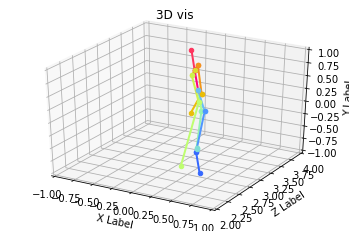

In [6]:
# for 3d vis
rg = [[-1,1], [-1,1], [2,4]]
ut.vis_3d(jt_cam,skel=skels, rg=rg)

